<a href="https://colab.research.google.com/github/Pramod560/django-deployment-example/blob/master/humanhorses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install kaggle


In [11]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pramod560","key":"3b1c3939d9c917e2bc29d2e2564f1aab"}'}

In [0]:
!mkdir -p ~/.kaggle


In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json


In [15]:
!kaggle datasets download -d sanikamal/horses-or-humans-dataset

 99% 305M/307M [00:05<00:00, 57.7MB/s]
100% 307M/307M [00:05<00:00, 62.1MB/s]


In [0]:
from zipfile import ZipFile

In [0]:
with ZipFile("horses-or-humans-dataset.zip") as zip:
  zip.extractall()

In [0]:
TRAIN_DIR = "horse-or-human/train"
TEST_DIR = "horse-or-human/validation"

In [0]:

import tensorflow as tf

In [46]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=128,
    target_size=(300,300),
    class_mode="binary"
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    batch_size=32,
    target_size=(300,300),
    class_mode="binary"

)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("accuracy")>=0.96):
      self.model.stop_training = True

In [48]:
from tensorflow import keras

callbacks = myCallback()
model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(300,300,3)),
                tf.keras.layers.MaxPooling2D(2,2),
                #tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
                tf.keras.layers.MaxPooling2D(2,2),
                #tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
                tf.keras.layers.MaxPooling2D(2,2),
                #tf.keras.layers.Dropout(0.3),
                #tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
                #tf.keras.layers.MaxPooling2D(2,2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512, 
                                      #kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                      bias_regularizer=tf.keras.regularizers.l2(1e-4),
                                      activity_regularizer=tf.keras.regularizers.l2(1e-5),
                                      activation="relu"),
                tf.keras.layers.Dense(1, activation="sigmoid")

])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 78400)            

In [50]:
history = model.fit_generator(
          train_generator,
          steps_per_epoch = 9,
          epochs=30,
          validation_data = test_generator,
          validation_steps=8,
          callbacks=[callbacks],
          verbose=1 
  
)

Epoch 1/30
9/9 [==============================] - 27s 3s/step - loss: 0.6926 - accuracy: 0.5492 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/30
9/9 [==============================] - 27s 3s/step - loss: 0.6918 - accuracy: 0.5988 - val_loss: 0.6906 - val_accuracy: 0.6250
Epoch 3/30
9/9 [==============================] - 30s 3s/step - loss: 0.6922 - accuracy: 0.4859 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 4/30
9/9 [==============================] - 27s 3s/step - loss: 0.6919 - accuracy: 0.5492 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 5/30
9/9 [==============================] - 27s 3s/step - loss: 0.6907 - accuracy: 0.5667 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 6/30
9/9 [==============================] - 27s 3s/step - loss: 0.6875 - accuracy: 0.6115 - val_loss: 0.6802 - val_accuracy: 0.6484
Epoch 7/30
9/9 [==============================] - 27s 3s/step - loss: 0.6704 - accuracy: 0.6436 - val_loss: 0.6551 - val_accuracy: 0.6406
Epoch 8/30
9/9 [==================

In [51]:
model.save("model/horse-or-human.model")

INFO:tensorflow:Assets written to: model/horse-or-human.model/assets


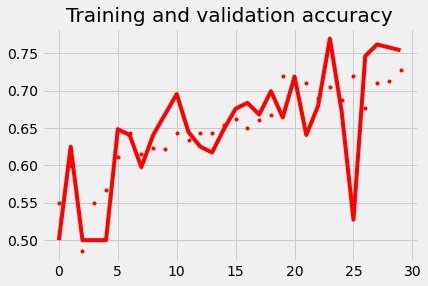

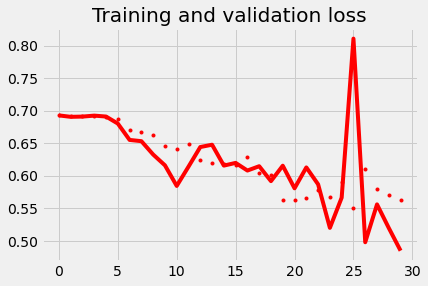

In [52]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

In [53]:
import numpy as np
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(300,300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


Saving Screenshot from 2020-05-24 15-50-52.png to Screenshot from 2020-05-24 15-50-52.png
Saving Screenshot from 2020-05-24 15-50-18.png to Screenshot from 2020-05-24 15-50-18.png
Saving Screenshot from 2020-05-24 15-49-57.png to Screenshot from 2020-05-24 15-49-57.png
Saving Screenshot from 2020-05-24 15-49-33.png to Screenshot from 2020-05-24 15-49-33.png
Saving Screenshot from 2020-05-24 15-49-02.png to Screenshot from 2020-05-24 15-49-02.png
Saving Screenshot from 2020-05-24 15-48-49.png to Screenshot from 2020-05-24 15-48-49 (4).png
Saving Screenshot from 2020-05-24 15-48-37.png to Screenshot from 2020-05-24 15-48-37 (4).png
Saving Screenshot from 2020-05-24 15-32-48.png to Screenshot from 2020-05-24 15-32-48 (4).png
[0.]
Screenshot from 2020-05-24 15-50-52.png is a horse
[0.]
Screenshot from 2020-05-24 15-50-18.png is a horse
[1.]
Screenshot from 2020-05-24 15-49-57.png is a human
[1.]
Screenshot from 2020-05-24 15-49-33.png is a human
[0.]
Screenshot from 2020-05-24 15-49-02.png

In [54]:
!pip install h5py


In [55]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
